# 13. 태깅 작업(Tagging Task)

## 4) 개체명 인식의 BIO 표현 이해하기

양방향 LSTM을 이용해서 개체명 인식기를 만들어봅니다.

### 1. BIO 표현

B는 Begin의 약자로 개체명이 시작되는 부분, I는 Inside의 약자로 개체명의 내부 부분을 의미하며, O는 Outside의 약자로 개체명이 아닌 부분을 의미합니다.

```
해 B                                        해 B-movie
리 I                                        리 I-movie
포 I                                        포 I-movie
터 I                                        터 I-movie
보 O                                        보 O
러 O                                        러 O
가 O                                        메 B-theater
자 O                                        가 I-theater
                                            박 I-theater
                                            스 I-theater
                                            가 O
                                            자 O
```

### 2. 개체명 인식 데이터 이해하기

```
EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER
```

데이터의 형식은 [단어] [품사 태깅] [청크 태깅] [개체명 태깅]의 형식으로 되어있습니다.

### 3. 데이터 전처리하기

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
f = open('datasets/train_1304.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [5]:
print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  14040


In [6]:
print('첫번째 샘플 :',tagged_sentences[0])

첫번째 샘플 : [['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 합니다.

In [7]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [11]:
print('첫번째 샘플의 문장 :', sentences[0])
print()
print('첫번째 샘플의 레이블 :', ner_tags[0])

첫번째 샘플의 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

첫번째 샘플의 레이블 : ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [10]:
print(sentences[12])
print()
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']

['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.502635


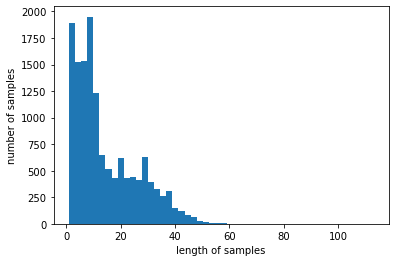

In [12]:
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))

plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [13]:
vocab_size = 4000
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [14]:
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'. format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'. format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


정수 인코딩을 수행합니다.

In [15]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [16]:
print('첫번째 샘플의 문장 :',X_train[0])
print()
print('첫번째 샘플의 레이블 :',y_train[0])

첫번째 샘플의 문장 : [989, 1, 205, 629, 7, 3939, 216, 1, 3]

첫번째 샘플의 레이블 : [4, 1, 7, 1, 1, 1, 7, 1, 1]


현재 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체된 상황입니다. 디코딩 작업을 진행해봅시다. 

In [17]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 각 정수로 변환된 단어에 대해서
    decoded.append(index_to_word[index]) # 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print()
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


패딩을 진행합니다.

In [18]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=.2, 
                                                    random_state=777)

원-핫 인코딩을 수행합니다.

In [20]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [21]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2808, 70)
테스트 샘플 레이블의 크기 : (2808, 70, 10)


### 4. 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

이번 실습과 같이 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정하여 숫자 0은 연산에서 제외시킨다는 옵션을 줄 수 있습니다. 

출력층에 TimeDistributed()를 사용했는데, TimeDistributed()는 LSTM을 다 대 다 구조로 사용하여 LSTM의 모든 시점에 대해서 출력층을 사용할 필요가 있을 때 사용합니다.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001),
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=8, 
          validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 12s 43ms/step - loss: 0.2008 - accuracy: 0.8232 - val_loss: 0.1322 - val_accuracy: 0.8324
Epoch 2/8
88/88 [==============================] - 2s 23ms/step - loss: 0.1067 - accuracy: 0.8459 - val_loss: 0.0873 - val_accuracy: 0.8694
Epoch 3/8
88/88 [==============================] - 2s 23ms/step - loss: 0.0757 - accuracy: 0.8895 - val_loss: 0.0630 - val_accuracy: 0.9106
Epoch 4/8
88/88 [==============================] - 2s 24ms/step - loss: 0.0527 - accuracy: 0.9259 - val_loss: 0.0459 - val_accuracy: 0.9359
Epoch 5/8
88/88 [==============================] - 2s 23ms/step - loss: 0.0382 - accuracy: 0.9460 - val_loss: 0.0391 - val_accuracy: 0.9467
Epoch 6/8
88/88 [==============================] - 2s 24ms/step - loss: 0.0304 - accuracy: 0.9566 - val_loss: 0.0353 - val_accuracy: 0.9513
Epoch 7/8
88/88 [==============================] - 2s 23ms/step - loss: 0.0254 - accuracy: 0.9641 - val_loss: 0.0333 - val_accuracy: 0.9543
Epoch 8/8
88/88 [==

In [23]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 1s 6ms/step - loss: 0.0339 - accuracy: 0.9552

 테스트 정확도: 0.9552


실제로 맞추고 있는지를 임의의 테스트 샘플로부터(인덱스 10번) 직접 실제값과 비교해보겠습니다. 

index_to_word와 index_to_ner를 사용하여 테스트 데이터에 대한 예측값과 실제값을 비교 출력합니다.

In [24]:
i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict(np.array([X_test[i]]))

# 확률 벡터를 정수 레이블로 변경.
y_predicted = np.argmax(y_predicted, axis=-1)

# 원-핫 벡터를 정수 인코딩으로 변경.
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], 
                                      index_to_ner[tag].upper(), 
                                      index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
pre